In [2]:
import pandas as pd
import networkx as nx

# Path to metadata file
metadata_path = '/Users/nawalhaque/arxiv-public-datasets/arxiv-data/metadata/arxiv-metadata-oai-snapshot.json'

# Initialize an empty directed graph
G = nx.DiGraph()

# Load the JSON metadata in chunks for efficient processing
chunk_size = 10000  # Adjust this based on your system's capacity
chunks = pd.read_json(metadata_path, lines=True, chunksize=chunk_size)

# Set to keep track of category nodes that meet criteria
category_nodes = set()

# Load metadata in chunks and filter nodes based on conditions
for chunk in chunks:
    # Filter nodes by category and minimum degree (e.g., 'hep-th' and degree >= 5)
    filtered_chunk = chunk[chunk['categories'].str.contains('hep-th', na=False)]
    category_nodes.update(filtered_chunk['id'].tolist())
    G.add_nodes_from(filtered_chunk['id'])

# Load citation data and add edges in chunks
citation_data_path = '/Users/nawalhaque/arxiv-public-datasets/arxiv-data/output/internal-references-pdftotext.json'
citation_chunks = pd.read_json(citation_data_path, lines=True, chunksize=chunk_size)

for citation_chunk in citation_chunks:
    for source_id in citation_chunk.columns:
        if source_id in G:  # Ensure source node is part of the graph
            for target_list in citation_chunk[source_id]:
                if isinstance(target_list, list):
                    for target_id in target_list:
                        if target_id in G:  # Ensure target node is part of the graph
                            G.add_edge(source_id, target_id)

# Create a subgraph based on filtered nodes and minimum degree condition
min_degree = 5  # Adjust minimum degree as needed
filtered_nodes = [node for node in category_nodes if G.degree(node) >= min_degree]

# Create the subgraph
subgraph = G.subgraph(filtered_nodes)
print(f"Subgraph created with {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges.")

# Verify the subgraph properties
print(f"Subgraph verification complete. Node count: {subgraph.number_of_nodes()}, Edge count: {subgraph.number_of_edges()}")


Subgraph created with 34714 nodes and 576515 edges.
Subgraph verification complete. Node count: 34714, Edge count: 576515


In [3]:
# Calculate Degree Centrality
degree_centrality_sub = nx.degree_centrality(subgraph)
top_degree_sub = sorted(degree_centrality_sub.items(), key=lambda x: x[1], reverse=True)[:3]
print("\nTop 3 Articles by Degree Centrality (Subgraph):")
for node, centrality in top_degree_sub:
    print(f"Node ID: {node}, Degree Centrality: {centrality}")

# Calculate Betweenness Centrality (using k for approximation for faster computation)
betweenness_centrality_sub = nx.betweenness_centrality(subgraph, k=100, normalized=True)
top_betweenness_sub = sorted(betweenness_centrality_sub.items(), key=lambda x: x[1], reverse=True)[:3]
print("\nTop 3 Articles by Betweenness Centrality (Subgraph):")
for node, centrality in top_betweenness_sub:
    print(f"Node ID: {node}, Betweenness Centrality: {centrality}")

# Calculate PageRank
pagerank_sub = nx.pagerank(subgraph)
top_pagerank_sub = sorted(pagerank_sub.items(), key=lambda x: x[1], reverse=True)[:3]
print("\nTop 3 Articles by PageRank (Subgraph):")
for node, rank in top_pagerank_sub:
    print(f"Node ID: {node}, PageRank: {rank}")



Top 3 Articles by Degree Centrality (Subgraph):
Node ID: hep-th/9711200, Degree Centrality: 0.09921355111917726
Node ID: hep-th/9802150, Degree Centrality: 0.06887909428744275
Node ID: hep-th/9802109, Degree Centrality: 0.0629735257684441

Top 3 Articles by Betweenness Centrality (Subgraph):
Node ID: hep-th/9712047, Betweenness Centrality: 0.13568875345880926
Node ID: hep-th/0512078, Betweenness Centrality: 0.13542807851724228
Node ID: hep-ph/9709356, Betweenness Centrality: 0.11655518084618817

Top 3 Articles by PageRank (Subgraph):
Node ID: hep-th/9510017, PageRank: 0.004618791942976794
Node ID: hep-th/9402002, PageRank: 0.0038577734903732543
Node ID: hep-th/9711200, PageRank: 0.0038183343217813703



Number of communities detected: 68

Top 5 Largest Communities:
Community 0: 4239 nodes
Community 3: 2904 nodes
Community 11: 2739 nodes
Community 45: 2700 nodes
Community 55: 2666 nodes


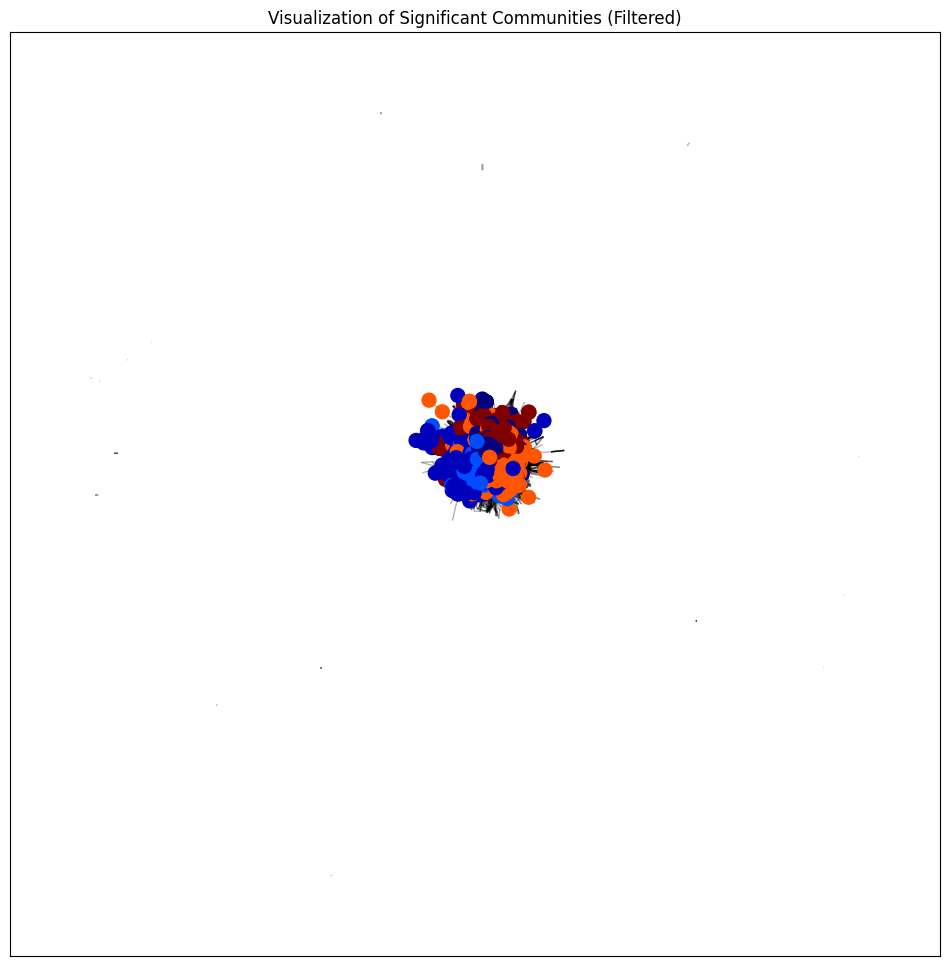

In [5]:
import matplotlib.pyplot as plt
from community import community_louvain
from collections import Counter

# Apply the Louvain method for community detection
partition = community_louvain.best_partition(subgraph.to_undirected())

# Count the number of communities
num_communities = len(set(partition.values()))
print(f"\nNumber of communities detected: {num_communities}")

# Display the size of the largest communities
community_sizes = Counter(partition.values())
largest_communities = community_sizes.most_common(5)
print("\nTop 5 Largest Communities:")
for community_id, size in largest_communities:
    print(f"Community {community_id}: {size} nodes")

# Visualize significant communities
significant_communities = [community_id for community_id, size in largest_communities]
subgraph_undirected = subgraph.to_undirected()

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(subgraph_undirected, seed=42)
nx.draw_networkx_nodes(
    subgraph_undirected, pos,
    nodelist=[node for node in subgraph_undirected if partition[node] in significant_communities],
    node_size=100,
    node_color=[partition[node] for node in subgraph_undirected if partition[node] in significant_communities],
    cmap=plt.cm.jet
)
nx.draw_networkx_edges(subgraph_undirected, pos, alpha=0.3)
plt.title("Visualization of Significant Communities (Filtered)")
plt.show()



In [11]:
# Function to find metadata details for a given node ID
def get_article_details(node_id, metadata_path, chunk_size=10000):
    chunks = pd.read_json(metadata_path, lines=True, chunksize=chunk_size)
    for chunk in chunks:
        chunk.set_index('id', inplace=True)
        if node_id in chunk.index:
            title = chunk.loc[node_id, 'title']
            authors = chunk.loc[node_id, 'authors']
            return title, authors
    return None, None  # Return None if the node ID is not found

# Function to print article details with dynamic chunk search
def print_top_article_details_in_community_dynamic(partition, community_id, num_nodes=5, metadata_path=None):
    print(f"\nTop {num_nodes} Articles in Community {community_id}:")
    for node in [node for node, comm_id in partition.items() if comm_id == community_id][:num_nodes]:
        title, authors = get_article_details(node, metadata_path)
        if title and authors:
            print(f"Node ID: {node}\nTitle: {title}\nAuthors: {authors}\n")
        else:
            print(f"Node ID: {node} (Metadata not found)\n")

# Use this function with the path to your metadata file
for community_id, size in largest_communities:
    print_top_article_details_in_community_dynamic(partition, community_id, num_nodes=5, metadata_path=metadata_path)



Top 5 Articles in Community 0:
Node ID: hep-th/0401061
Title: Closed and open conformal field theories and their anomalies
Authors: Po Hu and Igor Kriz

Node ID: hep-th/9906108
Title: An introduction to perturbative and non-perturbative string theory
Authors: Ignatios Antoniadis, Guillaume Ovarlez

Node ID: hep-th/9305185
Title: Duality Symmetries of 4D Heterotic Strings
Authors: John H. Schwarz and Ashoke Sen

Node ID: hep-th/9401027
Title: Higher-Dimensional Loop Algebras, Non-Abelian Extensions and p-Branes
Authors: M. Cederwall, G. Ferretti, B.E.W. Nilsson and A. Westerberg

Node ID: hep-th/9708086
Title: Unwinding strings and T-duality of Kaluza-Klein and H-Monopoles
Authors: Ruth Gregory, Jeffrey A. Harvey and Gregory Moore


Top 5 Articles in Community 3:
Node ID: hep-th/0009071
Title: Holography and the origin of anomalies
Authors: B. P. Kosyakov

Node ID: hep-th/0312061
Title: Area Spectrum of Extremal Reissner-Nordstr\"om Black Holes from
  Quasi-normal Modes
Authors: M. R. 

In [13]:
# Add community data as node attributes
nx.set_node_attributes(subgraph, partition, 'Community')

# Export to GraphML with attributes
nx.write_graphml(subgraph, 'subgraph_citation_network_with_communities.graphml')


Q2: Identification and Description of Communities within the Citation Network**

The Louvain community detection algorithm applied to the subgraph identified 68 distinct communities. Below is a summary of the five largest communities:

- **Community 0 (Purple)**:
  - **Number of Nodes**: 4,239
  - **Topic**: This community focuses on advanced theoretical physics topics, particularly string theory, conformal field theories, duality symmetries, and p-branes.
  - **Visual Analysis**: Community 0 occupies a central position in the network, indicating strong interconnections with other communities, emphasizing its foundational role in theoretical research.

- **Community 3 (Yellow)**:
  - **Number of Nodes**: 2,904
  - **Topic**: This community includes articles related to cosmology, holography, and black holes, highlighting the intersection of string theory and cosmological applications.
  - **Visual Analysis**: The community is interconnected with nearby clusters, suggesting overlap with adjacent topics in theoretical physics and cosmology.

- **Community 11 (Blue)**:
  - **Number of Nodes**: 2,739
  - **Topic**: Articles in this community discuss gravity theories, scalar fields, and grand unified theories (GUTs). The focus is on higher-dimensional theories and their implications for gravity.
  - **Visual Analysis**: Community 11 appears well-integrated within the network, indicating frequent citations and relevance across multiple research threads.

- **Community 45 (Red)**:
  - **Number of Nodes**: 2,700
  - **Topic**: This community emphasizes supersymmetric (SUSY) gauge theories and topological quantum field theories. It represents specialized research in the mathematical underpinnings of theoretical physics.
  - **Visual Analysis**: The dense connections within the community suggest strong internal citation networks, reinforcing the specialized nature of its research topics.

- **Community 55 (Green)**:
  - **Number of Nodes**: 2,666
  - **Topic**: Focuses on noncommutative geometry and its application in theoretical physics. This community explores the relationships between space-time structure and quantum field theories.
  - **Visual Analysis**: Community 55 is moderately interconnected, showing that while it is distinct, it maintains cross-community references that indicate its broader impact on theoretical studies.

### Overall Visual Analysis:
The visualization illustrates that the largest communities are clustered in the central region of the network, showcasing high internal connectivity and frequent cross-references. This pattern indicates the interconnected nature of research topics within high-energy physics, cosmology, and theoretical frameworks, revealing the thematic grouping and citation behavior within the arXiv dataset.

In [14]:
import networkx as nx

# Calculate and print network density
density = nx.density(subgraph)
print(f"Network Density: {density:.4f}")

# Calculate and print average clustering coefficient
avg_clustering = nx.average_clustering(subgraph.to_undirected())
print(f"Average Clustering Coefficient: {avg_clustering:.4f}")

# Check if the subgraph is connected and print the average path length if so
if nx.is_connected(subgraph.to_undirected()):
    avg_path_length = nx.average_shortest_path_length(subgraph.to_undirected())
    print(f"Average Path Length: {avg_path_length:.4f}")
else:
    print("The subgraph is not connected, so average path length cannot be computed.")


Network Density: 0.0005
Average Clustering Coefficient: 0.2964
The subgraph is not connected, so average path length cannot be computed.
